# Simulate Topological Time Crystal

**Author:** Chenning Tao

**Date:** 13/4/2024

Based on paper "[Digital quantum simulation of Floquet symmetry-protected topological phases][1]"

[1]: https://www.nature.com/articles/s41586-022-04854-3


In this part, we will demonstrate how to simulate topology time crystal using Qiskit on our cloud platform and compare the simulated result with the real experiment result.

### Floquet Symmetry-protected Topological Time Phase （FSPT）

Time crystal 是什么, Floquet Symmetry-protected Topological Time Phase的crystal是什么, 放下那个分类图，再哪里，基于下面俩特征进行分类

1. 特性1
2. 特性2


These features are reflected on the time-periodic Hamiltonian of the qubits:
$$\begin{gathered}
H(t)= \begin{cases}H_1, & \text { for } 0 \leq t<T^{\prime}, \\
H_2, & \text { for } T^{\prime} \leq t<T,\end{cases} \\
H_1 \equiv\left(\frac{\pi}{2}-\delta\right) \sum_k \hat{\sigma}_k^x, \\
H_2 \equiv-\sum_k\left[J_k \hat{\sigma}_{k-1}^z \hat{\sigma}_k^x \hat{\sigma}_{k+1}^z+V_k \hat{\sigma}_k^x \hat{\sigma}_{k+1}^x+h_k \hat{\sigma}_k^x\right]
\end{gathered}$$
where H1 ...., H2...


## Build circuit function for FSPT phase

The Hamiltonian mentioned above can be decomposed into the circuit shown in the figure.

<div style="text-align:center;">
    <img src="./pictures/4-2.circuit.png"  width="45%" height="45%">
</div>

The $H_1$ corresponds to the circuit in green background.

In [18]:
# import necessary dependencies
import qiskit
import numpy as np
from qiskit import *

# define the number of qubits, in this tutorial we use 8 qubits
num_qubits = 8

# construct the quantum circuit corrsponding to H1
def H1_FSPT(qc):
    # apply RX gates to all qubits with angle 0.99*pi
    for j in range(num_qubits):
        qc.rx(np.pi * 0.99, j)
    return qc

qc = QuantumCircuit(num_qubits)
print(H1_FSPT(qc))

     ┌────────────┐
q_0: ┤ Rx(3.1102) ├
     ├────────────┤
q_1: ┤ Rx(3.1102) ├
     ├────────────┤
q_2: ┤ Rx(3.1102) ├
     ├────────────┤
q_3: ┤ Rx(3.1102) ├
     ├────────────┤
q_4: ┤ Rx(3.1102) ├
     ├────────────┤
q_5: ┤ Rx(3.1102) ├
     ├────────────┤
q_6: ┤ Rx(3.1102) ├
     ├────────────┤
q_7: ┤ Rx(3.1102) ├
     └────────────┘


The $H_2$ corresponds to the circuit in yellow background. For the parameter of RY (Jk), we use randomly generated value from uniform distribution.

In [19]:
# construct the quantum circuit corrsponding to H2
from scipy.stats import uniform
def H2_FSPT(qc):
    # apply CRZ, the control qubit is odd, the target qubit is even, angle is pi
    for j in range(1, num_qubits, 2):
        qc.crz(np.pi, j-1, j)
    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(np.pi, j-1, j)

    # apply RY
    # generate the parameter from uniform distribution
    rand_values = uniform.rvs(-4, 4, size=num_qubits-2)
    for j in range(1, num_qubits-1):
        qc.ry(-2*(1 + rand_values[j-1]), j)

    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    for j in range(1, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    return qc

# show the quantum circuit
qc = QuantumCircuit(num_qubits)
print(H2_FSPT(qc))

                                                           
q_0: ────■───────────────────────────────────────────■─────
     ┌───┴───┐          ┌───────────┐            ┌───┴────┐
q_1: ┤ Rz(π) ├────■─────┤ Ry(4.997) ├──────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐ ├───────────┴┐ ┌───┴────┐└────────┘
q_2: ────■────┤ Rz(π) ├─┤ Ry(3.4561) ├─┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘┌┴────────────┴┐└────────┘┌───┴────┐
q_3: ┤ Rz(π) ├────■────┤ Ry(-0.52784) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐├──────────────┤┌───┴────┐└────────┘
q_4: ────■────┤ Rz(π) ├┤ Ry(-0.22807) ├┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘└┬────────────┬┘└────────┘┌───┴────┐
q_5: ┤ Rz(π) ├────■─────┤ Ry(4.0651) ├─────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐ ├────────────┤ ┌───┴────┐└────────┘
q_6: ────■────┤ Rz(π) ├─┤ Ry(4.2403) ├─┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘ └────────────┘ └────────┘┌───┴────┐
q_7: ┤ Rz(π) ├───────────────────────────────────┤ Rz(-π) ├
     └───────┘                          

# Build the circuit

We build the circuit using the above function according to the time step and add some initialization and measurement for the circuit.

In [20]:
def build_circuit(n):
    qc = QuantumCircuit(num_qubits)

    reversed = []
    # initialize the quantum state random orthogonal state of |0> and |1>
    for i in range(0, num_qubits):
        if np.random.rand() > 0.5:
            qc.x(i)
            reversed.append(num_qubits-i-1)

    # build circuit
    for i in range(1, n+1):
        # if is odd
        if i % 2 == 1:
            qc = H1_FSPT(qc)
        else:
            qc = H2_FSPT(qc)

    qc.measure_all()
    return qc, reversed


# Simulating

For each duration of time step, we caculate the expection based on the measurement result.

$$\overline{\left\langle\sigma_j^z(t)\right\rangle} = p_0 - p_1 = 1 - 2\times p_1$$

In [21]:
# run the quantum circuit
qc, reversed = build_circuit(2)
print(qc)
from qiskit import Aer, execute
from qiskit_aer.noise import NoiseModel, pauli_error
import qiskit_aer
from qiskit.extensions import IGate

I1 = IGate(label='i1')  # 20 ns identity gate
I2 = IGate(label='i2')  # 30 ns identity gate

# define the bit flip and phase flip error
e1 = 0.006
e2 = 0.01
error_1 = pauli_error([('X', e1/3), ('Y', e1/3), ('Z', e1/3),('I',1-e1)])
error_2 = pauli_error([('XX', e2/15), ('XY', e2/15), ('XZ', e2/15), 
                       ('YX', e2/15), ('YY', e2/15), ('YZ', e2/15), 
                       ('ZX', e2/15), ('ZY', e2/15), ('ZZ', e2/15), 
                       ('II',1-9/15*e2)])

backend = Aer.get_backend('qasm_simulator')

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cz'])

qc = transpile(qc, backend, basis_gates=['rx', 'ry', 'cz', 'x'])
res = backend.run(qc, shots=100, noise_model=noise_model).result().get_counts()

# calculate the expectation value of the Z operator
def expectation_value(res, i, reversed):
    total_counts = sum(res.values())
    p1 = 0
    for bitstring, count in res.items():
        if bitstring[i] == '1':
            p1 += count / total_counts
    if i in reversed:
        return -(1-2*p1)
    return 1 - 2*p1

for i in range(num_qubits):
    print(i, expectation_value(res, i, reversed))

        ┌────────────┐                                                »
   q_0: ┤ Rx(3.1102) ├──────────────────■─────────────────────────────»
        └───┬───┬────┘┌────────────┐┌───┴───┐          ┌────────────┐ »
   q_1: ────┤ X ├─────┤ Rx(3.1102) ├┤ Rz(π) ├────■─────┤ Ry(3.2368) ├─»
        ┌───┴───┴────┐└────────────┘└───────┘┌───┴───┐┌┴────────────┴┐»
   q_2: ┤ Rx(3.1102) ├──────────────────■────┤ Rz(π) ├┤ Ry(-0.40588) ├»
        └───┬───┬────┘┌────────────┐┌───┴───┐└───────┘└┬────────────┬┘»
   q_3: ────┤ X ├─────┤ Rx(3.1102) ├┤ Rz(π) ├────■─────┤ Ry(5.3409) ├─»
            ├───┤     ├────────────┤└───────┘┌───┴───┐ ├────────────┤ »
   q_4: ────┤ X ├─────┤ Rx(3.1102) ├────■────┤ Rz(π) ├─┤ Ry(1.1203) ├─»
        ┌───┴───┴────┐└────────────┘┌───┴───┐└───────┘ ├────────────┤ »
   q_5: ┤ Rx(3.1102) ├──────────────┤ Rz(π) ├────■─────┤ Ry(5.1736) ├─»
        ├────────────┤              └───────┘┌───┴───┐┌┴────────────┴┐»
   q_6: ┤ Rx(3.1102) ├──────────────────■────┤ Rz(π) ├┤ Ry(-0.33

# Draw the result

We can compare our result with the experiment result. For each point in the figure, we generate and run teh circuit for 100 times (ATTENTION: this could take a while!).

<div style="text-align:center;">
    <img src="./pictures/4-2.result.png"  width="50%" height="50%">
</div>

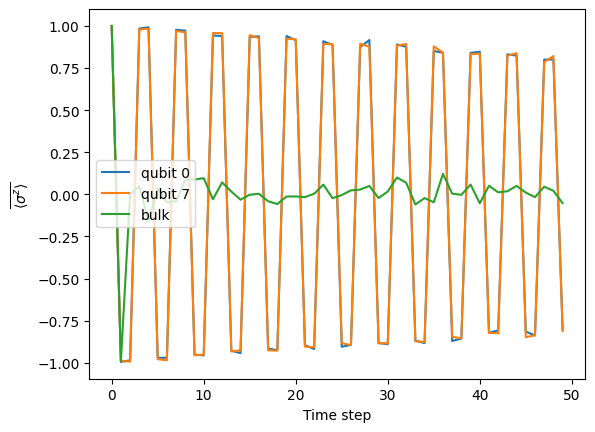

In [22]:
import matplotlib.pyplot as plt

res = []

# collect the result for time step from 1 to 50
for i in range(0, 50):
    # repeat 100 times
    res0 = 0
    res_mid = 0
    res7 = 0
    repeat_time = 20
    for _ in range(repeat_time):
        qc, reversed = build_circuit(i)
        qc = transpile(qc, backend)
        result = backend.run(qc, shots=100, noise_model=noise_model).result().get_counts()
        res_0 = expectation_value(result, 0, reversed)
        mid = 0
        for j in range(1, num_qubits-1):
            mid += expectation_value(result, j, reversed)
        res_7 = expectation_value(result, num_qubits-1, reversed)
        res0 += res_0
        res7 += res_7
        res_mid += mid / (num_qubits-2)
    res0 /= repeat_time
    res_mid /= repeat_time
    res7 /= repeat_time
    res.append([res0, res7, res_mid])

# plot the result
plt.plot(res)
plt.xlabel('Time step')
plt.ylabel(r'$\overline{\left\langle\sigma^z\right\rangle}$')
plt.legend(['qubit 0', 'qubit 7', 'bulk'])
plt.show()

TODO:
    解释pattern